MLP - Classification Task - Adam + PSO

In [20]:
import tensorflow as tf
import numpy as np, random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import os
from deap import base, creator, tools, algorithms

In [21]:
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

In [22]:
#plot_path = "/content/drive/MyDrive/plots"

In [23]:
def create_mlp(dimensions, X_train, y_train, X_test, y_test):
    input_dim, num_hidden_layers, neurons_per_layer, output_dim = dimensions
    model = Sequential()
    model.add(Input(shape=(input_dim,)))

    for _ in range(num_hidden_layers):
        model.add(Dense(neurons_per_layer, activation='relu'))

    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer ='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    return model

In [24]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test)
    return loss, accuracy

In [25]:
def update_weights(model, position):
    idx = 0
    for layer in model.layers:
        if isinstance(layer, Dense) and layer.trainable:
            weights_shape = layer.kernel.shape
            # Update weights and biases of the model
            weights_size = np.prod(weights_shape)
            weights = position[idx:idx+weights_size].reshape(weights_shape)
            layer.kernel.assign(weights)
            idx += weights_size

    return model

In [26]:
def get_weights_model(model):
    allWeights = []
    for layer in model.layers:
        if isinstance(layer, Dense) and layer.trainable:
           weights = layer.get_weights()[0]
           allWeights.extend(weights.flatten())
    return allWeights

In [27]:
class Particle:
      def __init__(self, position, velocity):
          self.position = position
          self.velocity = velocity
          self.fitness = float('inf') #loss
          self.accuracy = float('inf') #accuracy
          self.local_best_position = position

      def set_local_best(self, local_best_position):
          self.local_best_position = local_best_position

      def update_velocity(self, inertia_weight, cognitive_weight, social_weight, global_best_position):
          r1, r2 = np.random.rand(2)
          congnitive_component = cognitive_weight * r1 * (self.local_best_position - self.position)
          social_component = social_weight * r2 * (global_best_position - self.position)
          self.velocity = (inertia_weight * self.velocity + congnitive_component + social_component)
          #print("Velocity", self.velocity)

      def update_position(self):
          #print("Position", self.position)
          self.position += self.velocity

      def evaluate_fitness(self, model, X_train, y_train, X_test, y_test):
          # update the weights & biases of the model given the particle
          model = update_weights(model, self.position)
          self.fitness, self.accuracy = evaluate_model(model, X_train, y_train, X_test, y_test)

Update the best swarm position once fitness related to each of the particles has been calculated.

In [28]:
import matplotlib.pyplot as plt

def plot_data(loss_data, accuracy_data, path):
    plt.figure(figsize=(8, 5))
    plt.plot(loss_data, label='loss', color='blue')
    plt.xlabel('Iteration')
    plt.ylabel('Loss', color='blue')
    plt.tick_params(axis='y', labelcolor='blue')

    plt.twinx()
    plt.plot(accuracy_data, label='accuracy', color='green')
    plt.ylabel('Accuracy', color='green')
    plt.tick_params(axis='y', labelcolor='green')

    plt.title('Loss and accuracy over the time')
    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.savefig(path)
    plt.legend(loc='upper left')
    plt.show()

In [29]:
def pso(n, max_trials, model, X_train, y_train, X_test, y_test,
        inertia_weight, cognitive_weight, social_weight):

    log_file='pso_log.txt'
    # Open log file
    with open(log_file, 'w') as f:
        f.write("Starting PSO Optimization\n")
        f.write("----------------------------------\n\n")

    weights_size = 0
    for layer in model.layers:
         weights_size += np.prod(layer.kernel.shape)

    pretrained_weights_biases = get_weights_model(model)

    all_particles = []
    global_best_position = np.zeros(weights_size) #combination of weights and biases
    global_best_fitness = float('inf') #minimum loss
    gloval_best_accuracy = float('inf') #accuracy corresponding to the best minimum loss

    local_best_position = np.zeros(weights_size) #combination of weights and biases
    local_best_fitness = float('inf') #minimum loss
    local_best_accuracy = float('inf') #accuracy corresponding to the best minimum loss
    noise_range = 0.01  # Initial noise range
    min_val = -10.0
    #max_val = 0.1
    max_val = 10.0
    tempLow = min_val * 0.01
    tempHigh = max_val * 0.01
    
    for _ in range(n):
        position = pretrained_weights_biases + np.random.uniform(tempLow, tempHigh, size=weights_size)
        velocity = np.random.uniform(tempLow, tempHigh, size=weights_size)

        particle = Particle(position, velocity)
        particle.update_position()
        particle.evaluate_fitness(model, X_train, y_train, X_test, y_test)

        if particle.fitness < global_best_fitness:
           local_best_fitness = particle.fitness
           local_best_position = particle.position
           local_best_accuracy = particle.accuracy

           global_best_fitness = particle.fitness
           global_best_position = particle.position
           global_best_accuracy = particle.accuracy

        all_particles.append(particle)

    # Initialize min_loss and max_loss
    min_loss = float('inf')  # Start with a very high value
    max_loss = float('-inf')  # Start with a very low value
    # Initialize min_ind and max_ind
    min_ind = -1
    max_ind = -1

    # Iterate through all particles
    for i in range(len(all_particles)):
        current_fitness = all_particles[i].fitness

        # Update min_loss and min_ind
        if current_fitness < min_loss:
            min_loss = current_fitness
            min_ind = i
        # Update max_loss and max_ind
        if current_fitness > max_loss:
            max_loss = current_fitness
            max_ind = i

    min_loss_data = []
    min_acc_data = []
    max_loss_data = []
    max_acc_data= []

    print(f"Best Global Loss/Fitness = {global_best_fitness}, Best Accuracy = {global_best_accuracy}")
    print(f"Best Local Loss/Fitness = {local_best_fitness}, Best Accuracy = {local_best_accuracy}")
    print("---------------------------------------------------------")
    tempLow = min_val * 0.0001
    tempHigh = max_val * 0.0001
    tol = 5
    patience = 0
    isEnd = False
    best_fitness_history = [global_best_fitness]
    for trial in range(max_trials):
        inertia_weight = inertia_weight * 0.99
        for i in range(n):
            current_particle = all_particles[i]
            current_particle.update_velocity(inertia_weight, cognitive_weight, social_weight, global_best_position)
            current_particle.velocity = np.clip(current_particle.velocity, tempLow, tempHigh)

            current_particle.update_position()
            current_particle.evaluate_fitness(model, X_train, y_train, X_test, y_test)

            if i == min_ind:
               min_loss_data.append(current_particle.fitness)
               min_acc_data.append(current_particle.accuracy)

            if i == max_ind:
               max_loss_data.append(current_particle.fitness)
               max_acc_data.append(current_particle.accuracy)

            if current_particle.fitness < local_best_fitness:
               local_best_fitness = current_particle.fitness
               local_best_position = current_particle.position
               local_best_accuracy = current_particle.accuracy
               current_particle.set_local_best(local_best_position)

            if current_particle.fitness < global_best_fitness:
                global_best_fitness = current_particle.fitness
                global_best_position = current_particle.position
                global_best_accuracy = current_particle.accuracy
                patience = 0
                best_fitness_history.append(global_best_fitness)

        if global_best_fitness >= min(best_fitness_history):
           patience += 1
            
        if patience >= tol:
           message = f"\nEarly stopping at trial {trial+1} - No improvement for {patience} consecutive trials."
           print(message)
           with open(log_file, 'a') as f:
                f.write(message + "\n")
           break
        else:
          message = f"Trial {trial+1}: Best Loss/Fitness PSO = {global_best_fitness}, Best Accuracy = {global_best_accuracy}"
          print(message)
          with open(log_file, 'a') as f:
              f.write(message + "\n")
              f.write("-----------------------------------------------------------------------------------------------" + "\n")
        

    path = 'plots/bcancer_perform_best_100.png'
    plot_data(min_loss_data, min_acc_data, path)
    path = 'plots/bcancer_perform_worst_100.png'
    plot_data(max_loss_data, max_acc_data, path)
    return global_best_position, global_best_fitness

In [30]:
# PSO parameters
n_particles = 30
max_trials = 100
w = 0.7  # Inertia weight
c1 = 1.5  # Cognitive parameter
c2 = 1.5  # Social parameter

In [31]:
def setup_run(X_train, X_test, y_train, y_test, dimensions, inertia_weight, cognitive_weight, social_weight):
    # Create a base model
    print("Before PSO")
    model = create_mlp(dimensions, X_train, y_train, X_test, y_test)
    evaluate_model(model, X_train, y_train, X_test, y_test)
    print("Now PSO estimations")
    pso(n_particles, max_trials, model, X_train, y_train, X_test, y_test, inertia_weight, cognitive_weight, social_weight)

In [32]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

In [33]:
## Load dataset and run
def load_and_run(dataset_loader):
    data = dataset_loader()
    X = data.data
    y = data.target.reshape(-1, 1)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    encoder = OneHotEncoder()
    y = encoder.fit_transform(y).toarray()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Dynamically setting input shape
    input_shape = X_train.shape[1]
    num_hidden_layers = 3
    neurons_per_layer = 5
    output_dim = y_train.shape[1]
    dimensions = input_shape, num_hidden_layers, neurons_per_layer, output_dim
    print(dimensions)
    setup_run(X_train, X_test, y_train, y_test, dimensions, w, c1, c2)

#usage
#load_and_run(load_iris)

In [34]:
'''from sklearn.datasets import load_wine
data = load_wine()
X, y = data.data, data.target
load_and_run(load_wine)'''

'from sklearn.datasets import load_wine\ndata = load_wine()\nX, y = data.data, data.target\nload_and_run(load_wine)'

In [35]:
'''from sklearn.datasets import load_digits
data = load_digits()
X, y = data.data, data.target
load_and_run(load_digits)'''

'from sklearn.datasets import load_digits\ndata = load_digits()\nX, y = data.data, data.target\nload_and_run(load_digits)'

In [36]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


Before PSO
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9707 - loss: 0.1055 
Now PSO estimations
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9558 - loss: 0.1431 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9558 - loss: 0.1015 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9558 - loss: 0.1133 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9558 - loss: 0.1143 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9558 - loss: 0.1414 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9558 - loss: 0.1223
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9578 - loss: 0.0969 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9672 - loss: 0.1013
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9763 - loss: 0.0871 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9522 - loss: 0.1121 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9522 - loss: 0.1312
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9728 - loss: 0.1002
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/

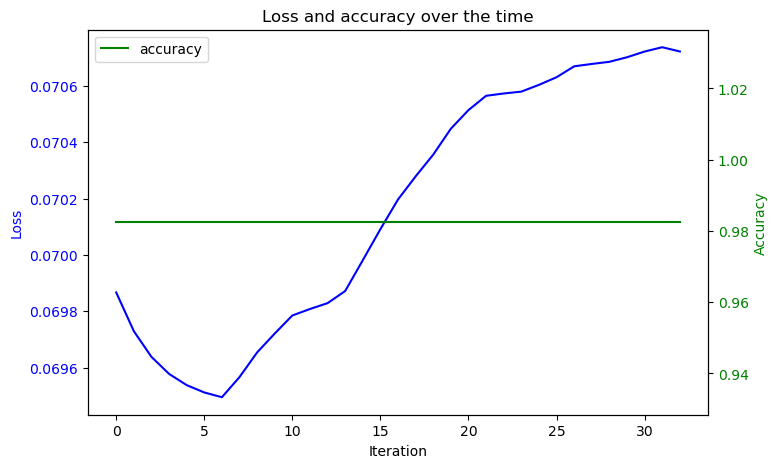

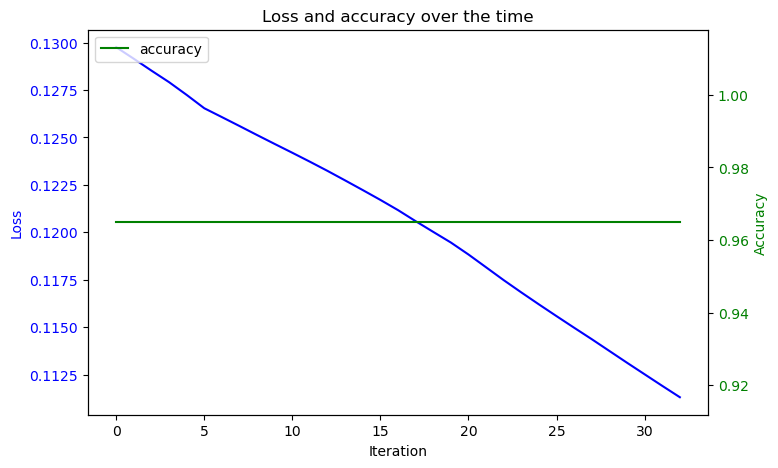

In [37]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# metadata
# print(breast_cancer_wisconsin_diagnostic.metadata)

# variable information
# print(breast_cancer_wisconsin_diagnostic.variables)

scaler = StandardScaler()
X = scaler.fit_transform(X)
encoder = OneHotEncoder()
y = encoder.fit_transform(y).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dynamically setting input shape
input_shape = X_train.shape[1]
num_hidden_layers = 3
neurons_per_layer = 5
output_dim = y_train.shape[1]
dimensions = input_shape, num_hidden_layers, neurons_per_layer, output_dim
setup_run(X_train, X_test, y_train, y_test, dimensions, w, c1, c2)


In [38]:
'''from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
spambase = fetch_ucirepo(id=94) 
  
# data (as pandas dataframes) 
X = spambase.data.features 
y = spambase.data.targets 

scaler = StandardScaler()
X = scaler.fit_transform(X)
encoder = OneHotEncoder()
y = encoder.fit_transform(y).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dynamically setting input shape
input_shape = X_train.shape[1]
num_hidden_layers = 3
neurons_per_layer = 5
output_dim = y_train.shape[1]
dimensions = input_shape, num_hidden_layers, neurons_per_layer, output_dim
setup_run(X_train, X_test, y_train, y_test, dimensions, w, c1, c2)'''


'from ucimlrepo import fetch_ucirepo \n  \n# fetch dataset \nspambase = fetch_ucirepo(id=94) \n  \n# data (as pandas dataframes) \nX = spambase.data.features \ny = spambase.data.targets \n\nscaler = StandardScaler()\nX = scaler.fit_transform(X)\nencoder = OneHotEncoder()\ny = encoder.fit_transform(y).toarray()\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Dynamically setting input shape\ninput_shape = X_train.shape[1]\nnum_hidden_layers = 3\nneurons_per_layer = 5\noutput_dim = y_train.shape[1]\ndimensions = input_shape, num_hidden_layers, neurons_per_layer, output_dim\nsetup_run(X_train, X_test, y_train, y_test, dimensions, w, c1, c2)'